## How good is the BSP - Historical performance

**Import relevant packages**

In [56]:
# import packages
import pandas as pd
import numpy as np
import datetime
import os
import shin
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service


**Import data**: Import and save all manually downloaded csvs of Betfair historical data in a dictionary - our analysis will loop through the csvs and perform the calcs

In [57]:
# when false will analysis US markets. 
aus_market = False

In [58]:
# lets download every csv from the folder_path and name is a different name:
if aus_market:
    folder_path = 'C:\\Users\\bened\\Documents\\Alameda-Project\\betfair_historical_data\\aus markets' #need to update to your project folder if you want to run
else: 
    folder_path = 'C:\\Users\\bened\\Documents\\Alameda-Project\\betfair_historical_data\\us markets'

# we need to get a list of all the files in the folder:
file_list = os.listdir(folder_path)
# we need to define an empty list to store the dataframes:
df_list = []
# we need to iterate through the list of files and read each file into a dataframe:
for file in file_list:
    # we need to define the path to the file:
    file_path = folder_path + '\\' + file
    # we need to read the csv file into a dataframe:
    df = pd.read_csv(file_path)
    # we need to append the dataframe to the list of dataframes:
    df_list.append(df)
# lets write a loop to go through each element of df_list and return the element saved as a unique name:
df_dict = {}
for i in range(len(df_list)):
    # we need to define the name of the dataframe as a string:
    name = 'df' + str(i)
    # we need to store the dataframe in a dictionary with its name as the key:
    df_dict[name] = df_list[i]

In [59]:
file_list

['dwbfpricesusawin04022021.csv',
 'dwbfpricesusawin05012023.csv',
 'dwbfpricesusawin06022021.csv',
 'dwbfpricesusawin07022021.csv',
 'dwbfpricesusawin08022021.csv',
 'dwbfpricesusawin08102022.csv',
 'dwbfpricesusawin09012023.csv',
 'dwbfpricesusawin10012023.csv',
 'dwbfpricesusawin11012023.csv',
 'dwbfpricesusawin11022021.csv',
 'dwbfpricesusawin11112022.csv',
 'dwbfpricesusawin11122022.csv',
 'dwbfpricesusawin12012023.csv',
 'dwbfpricesusawin12022021.csv',
 'dwbfpricesusawin12102022.csv',
 'dwbfpricesusawin12122022.csv',
 'dwbfpricesusawin13012023.csv',
 'dwbfpricesusawin13102022.csv',
 'dwbfpricesusawin13122022.csv',
 'dwbfpricesusawin14102022.csv',
 'dwbfpricesusawin14122022.csv',
 'dwbfpricesusawin16122022.csv',
 'dwbfpricesusawin17062021.csv',
 'dwbfpricesusawin18062021.csv',
 'dwbfpricesusawin18112022.csv',
 'dwbfpricesusawin19062021.csv',
 'dwbfpricesusawin20062021.csv',
 'dwbfpricesusawin26112022.csv',
 'dwbfpricesusawin28112022 (1).csv']

**Define useful functions**

In [60]:
#lets write a function that takes one of our dataframes as input and returns the total winnings from betting $1 on every horse:
def total_winnings(df):
    # We add a column that multiplies 1 * BSP if the horse won the race using a list comprehension:
    df['IMPLIED_PROB_WIN'] = np.where(df['WIN_LOSE'] == 1, 0.95 * (1 * df['BSP']), -1)
    # Now we need to sum the IMPLIED_PROB_WIN column for the entire dataframe:
    total_winnings = df['IMPLIED_PROB_WIN'].sum()
    return total_winnings

# lets write a function that takes one of our dataframes as input and returns how many unique EVENT_IDs there are:
def total_races(df):
    # We need to find the number of unique EVENT_IDs in the dataframe:
    total_r = df['EVENT_ID'].nunique()
    return total_r

# lets write a function that takes one of our dataframes and returns the cumulative implied probs for each race:
def cumulative_implied_probs(df):
    # let's make a column that calculates the implied odds
    df['BASE_IMPLIED_PROBS'] = (1 / df['BSP'])
    # we need to group the dataframe by EVENT_ID and sum the IMPLIED_PROB_WIN column:
    RACE_CUMULATIVE_PROBS = df.groupby('EVENT_ID').sum('BASE_IMPLIED_PROBS')['BASE_IMPLIED_PROBS']
    # we need to return the dataframe:
    return RACE_CUMULATIVE_PROBS

def implied_v_actuals(df):
    BASE_IMPLIED_PROBS = (1 / df['BSP'])
    WIN_LOSE = df['WIN_LOSE']
    df_implied_actuals = pd.DataFrame({'BASE_IMPLIED_PROBS': BASE_IMPLIED_PROBS, 'WIN_LOSE': WIN_LOSE})
    return df_implied_actuals
    
def grouping(row):
    if row['BASE_IMPLIED_PROBS'] < 0.1:
        return '0.1'
    elif row['BASE_IMPLIED_PROBS'] < 0.2:
        return '0.2'
    elif row['BASE_IMPLIED_PROBS'] < 0.3:
        return '0.3'
    elif row['BASE_IMPLIED_PROBS'] < 0.4:
        return '0.4'
    elif row['BASE_IMPLIED_PROBS'] < 0.5:
        return '0.5'
    elif row['BASE_IMPLIED_PROBS'] < 0.6:
        return '0.6'
    elif row['BASE_IMPLIED_PROBS'] < 0.7:
        return '0.7'
    elif row['BASE_IMPLIED_PROBS'] < 0.8:
        return '0.8'
    elif row['BASE_IMPLIED_PROBS'] < 0.9:
        return '0.9'
    elif row['BASE_IMPLIED_PROBS'] < 1:
        return '1'

#lets write a function that takes a df as input and outputs the df without any rows where WIN_LOSE == 2:
def remove_draws(df):
    # we need to remove any rows where WIN_LOSE == 2:
    df = df[df['WIN_LOSE'] != 2]
    # we need to return the dataframe:
    return df

**Apply functions to data**: Loop through each dataframe csv and apply functions - finally calculating the total winnings (if you bet $1, on every horse) and sample size of races. 

In [61]:
# lets loop through each value of dict, applying our functions:
total_races_list = []
total_winnings_list = []
total_cumulative_probs_list = []

for v in df_dict.values():
    v = remove_draws(v)
    # append the results to the list:
    tw = total_winnings(v)
    tr = total_races(v)
    tcp = cumulative_implied_probs(v)
    #append tw to total_winnings:
    total_winnings_list.append(tw)
    total_races_list.append(tr)
    total_cumulative_probs_list.append(tcp)

C:\Users\bened\AppData\Local\Temp\ipykernel_17148\2891138847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IMPLIED_PROB_WIN'] = np.where(df['WIN_LOSE'] == 1, 0.95 * (1 * df['BSP']), -1)
C:\Users\bened\AppData\Local\Temp\ipykernel_17148\2891138847.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BASE_IMPLIED_PROBS'] = (1 / df['BSP'])
C:\Users\bened\AppData\Local\Temp\ipykernel_17148\2891138847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [62]:
df_bsp_how_good = []
for v in df_dict.values():
    v = remove_draws(v)
    nuisance_df = implied_v_actuals(v)
    df_bsp_how_good.append(nuisance_df)
df_bsp_how_good = pd.concat(df_bsp_how_good)

In [63]:
# lets count how many times WIN_LOSe == 2 in df_bsp_how_good:
df_bsp_how_good['WIN_LOSE'].value_counts()

0    10130
1     1484
Name: WIN_LOSE, dtype: int64

Table of sample sizes for each group:
       BASE_IMPLIED_PROBS  WIN_LOSE
Group                              
0.1                  6241      6241
0.2                  2755      2755
0.3                  1448      1448
0.4                   657       657
0.5                   302       302
0.6                   138       138
0.7                    55        55
0.8                    14        14
0.9                     4         4


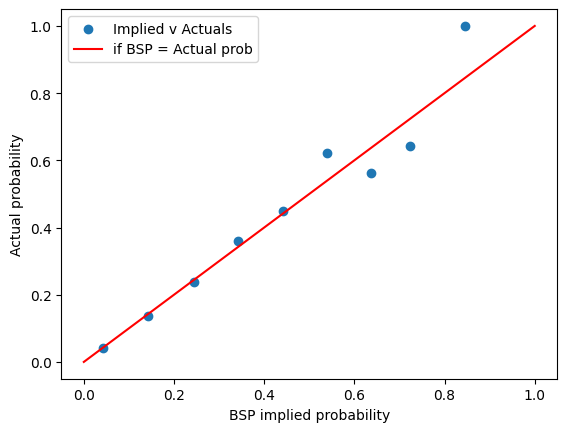

In [64]:
df_bsp_how_good['Group'] = df_bsp_how_good.apply(grouping, axis=1)
actuals_v_implied = df_bsp_how_good.groupby('Group').mean()
#lets count the numbers from each group:
sample_sizes = df_bsp_how_good.groupby('Group').count()

print('Table of sample sizes for each group:')
print(sample_sizes)
plt.scatter(actuals_v_implied['BASE_IMPLIED_PROBS'], actuals_v_implied['WIN_LOSE'])
#draw 45 degree line:
plt.plot([0,1], [0,1], color='red')
#add x and y labels:
plt.xlabel('BSP implied probability')
plt.ylabel('Actual probability')
plt.legend(['Implied v Actuals','if BSP = Actual prob'])
plt.show()


In [65]:
actuals_v_implied = df_bsp_how_good.groupby('Group').mean()
actuals_v_implied

,BASE_IMPLIED_PROBS,WIN_LOSE
Group,,
0.1,0.042154,0.041660
0.2,0.143156,0.136842
0.3,0.243889,0.237569
0.4,0.342175,0.360731
0.5,0.441678,0.450331
0.6,0.539473,0.623188
0.7,0.636758,0.563636
0.8,0.722897,0.642857
0.9,0.845972,1.000000


**Plot key results**

total winnings of betting $1 on every horse: 467.28501277973396, from a sample of 874 races


Text(0.5, 0, 'Race day winnings from $1 on every horse')

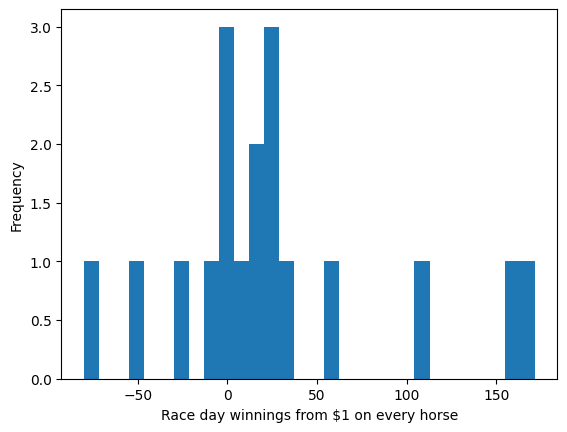

In [11]:
print(f'total winnings of betting $1 on every horse: {sum(total_winnings_list)}, from a sample of {sum(total_races_list)} races')

plt.hist(total_winnings_list, bins = 30)  
plt.ylabel('Frequency')
plt.xlabel('Race day winnings from $1 on every horse')

For every horse we have calculated the implied probability of winning from the BSP (simply 1 / BSP), then we add these up for every race. Below is a histogram of the frequencies of the cumulative race probability for every race.

In [12]:
total_cumulative_probs_list = total_cumulative_probs_list[0].astype(float)
plt.hist(total_cumulative_probs_list, bins = 30)  
plt.ylabel('Frequency')
plt.xlabel('Cumulative Race Probability')

#let's calculate the standard deviation of the list:
sd = np.std(total_cumulative_probs_list)
mean = np.mean(total_cumulative_probs_list)
print(f'mean: {mean}, Error / SD of below is: {sd}, from a sample of {sum(total_races_list)} races')

IndexError: list index out of range

Below is Ben playing around